<center>
    <h1>Fruit Inspection - Second Task: Russet Detection</h1>
    <h2>Image Processing and Computer Vision</h2>
    <h3>Facundo Nicolas Maidana and Riccardo Spolaor</h3>
    <h4>facundo.maidana@studio.unibo.it; riccardo.spolaor@studio.unibo.it</h4>
</center>

---

This notebook presents the development of a system aimed at locating defects and imperfection in fruits. Each fruit is acquired through a NIR *(Near Infra-Red)* and color camera that present little parallax effect among each other.

<table>
    <tr>
        <td><img src="images/second task/C0_000004.png" width="200"/></td>
        <td><img src="images/second task/C1_000004.png" width="200"/></td>
    </tr>
    <tr>
        <td style='text-align:left'>NIR example</td>
        <td style='text-align:left'>Color example</td>
    </tr>
</table>

# 00 Prerequisites
The libraries necessary for the task are imported.

In [35]:
%matplotlib inline

import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.image import extract_patches_2d
from time import process_time, time

# Utils libraries
from graphics import *
from utils import *

The cell below illustrates the version of `OpenCV` used for the task.

In [2]:
print(f'Using OpenCV version: {cv2.__version__}.')

Using OpenCV version: 4.6.0.


The random seed is set for both the `numpy` and `OpenCV` libraries in order to guarantee reproducibility of results.

In [3]:
SEED = 42

cv2.setRNGSeed(SEED)
np.random.seed(SEED)

# 01 Image analysis 
The series of images is firstly imported and plotted.

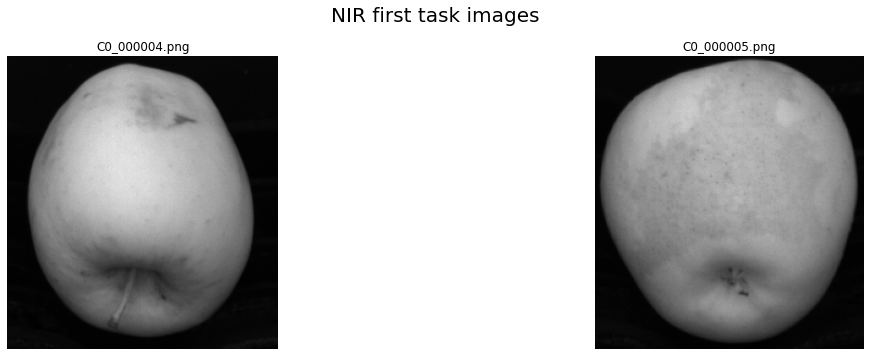

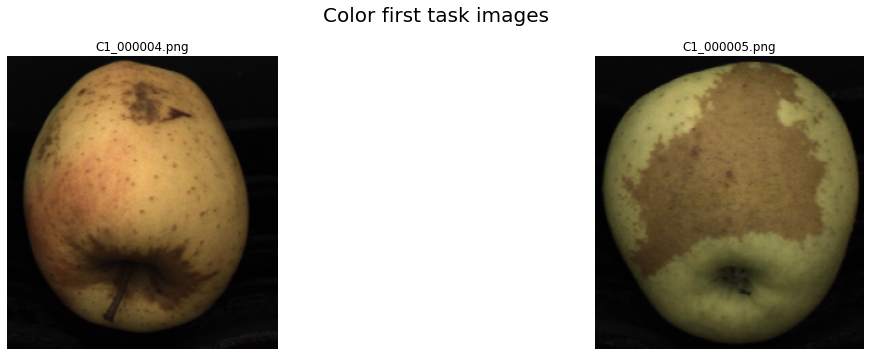

In [4]:
# Create two arrays containing the names of the NIR and color images respectively
nir_names, colour_names = [[f'C{j}_00000{i}.png' for i in [4, 5]] for j in [0,1]]

# Directory where the images are saved
DIR = 'images/second task/'

# Import NIR and colour images
nir_imgs = [cv2.imread(f'{DIR}{img}', cv2.IMREAD_GRAYSCALE) for img in nir_names]
colour_imgs = [cv2.imread(f'{DIR}{img}') for img in colour_names]

# Plot the NIR and color images
plot_image_grid(nir_imgs, 'NIR first task images', nir_names)
plot_image_grid(colour_imgs, 'Color first task images', colour_names)

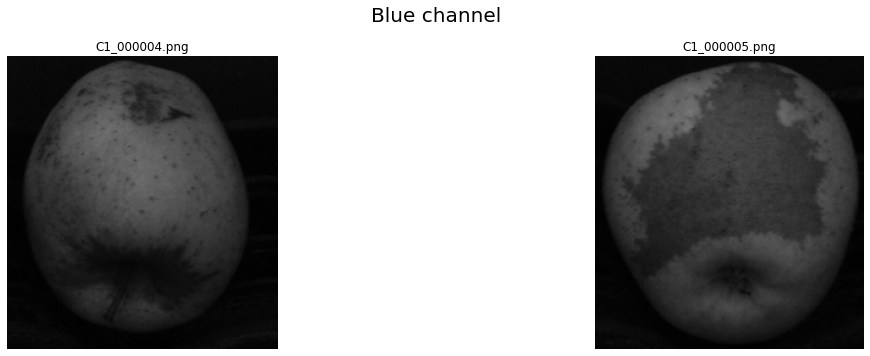

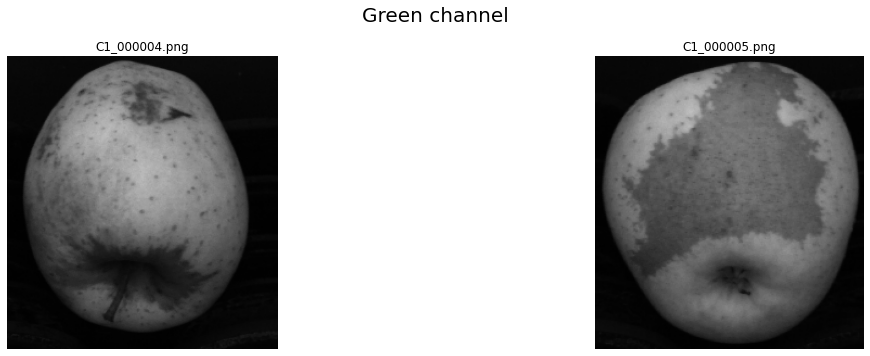

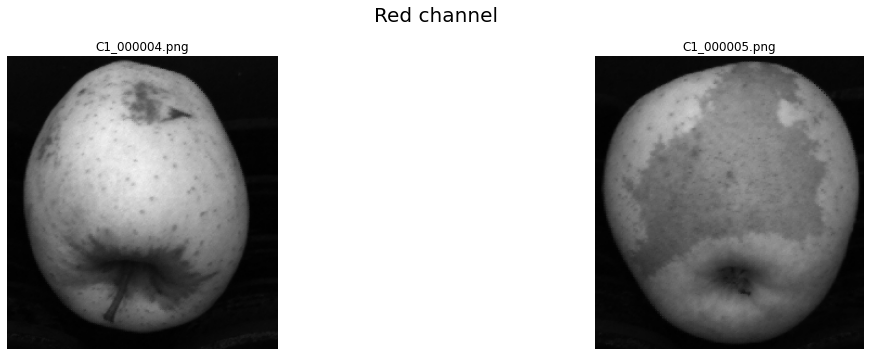

In [5]:
colour_B = []; colour_G = []; colour_R = []

for img in colour_imgs:
    B, G, R = cv2.split(img)
    colour_B.append(B)
    colour_G.append(G)
    colour_R.append(R)

# Plot the Channels of the images
plot_image_grid(colour_B, 'Blue channel', colour_names)
plot_image_grid(colour_G, 'Green channel', colour_names)
plot_image_grid(colour_R, 'Red channel', colour_names)

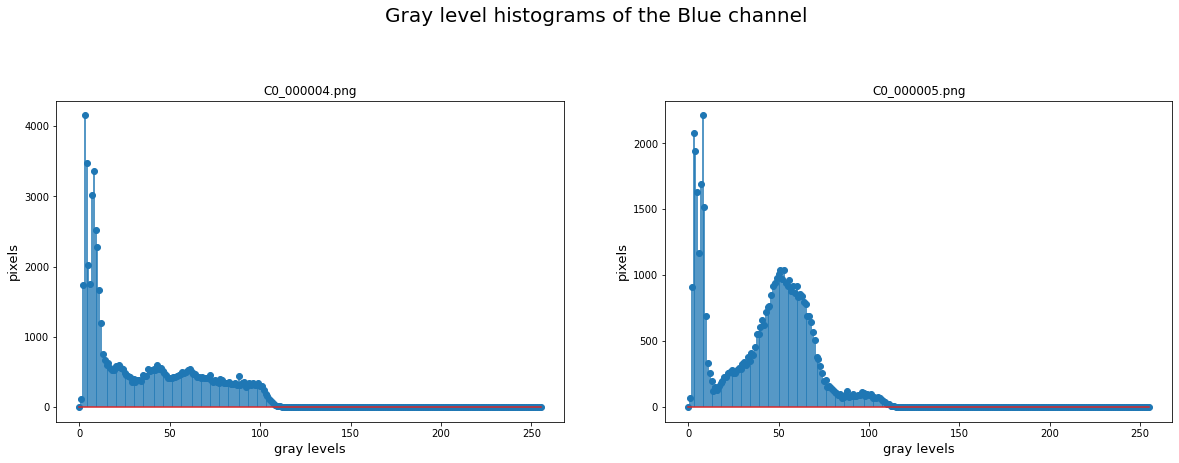

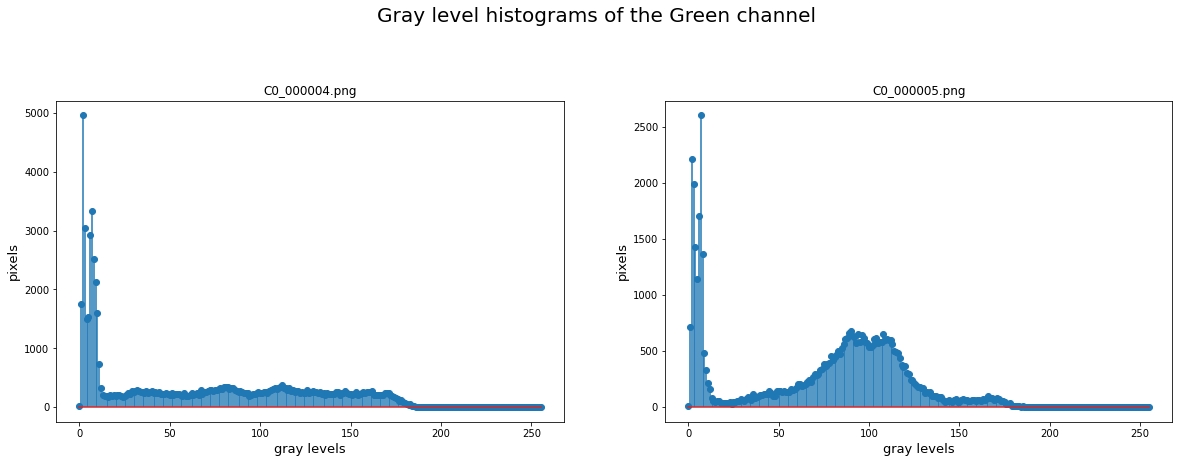

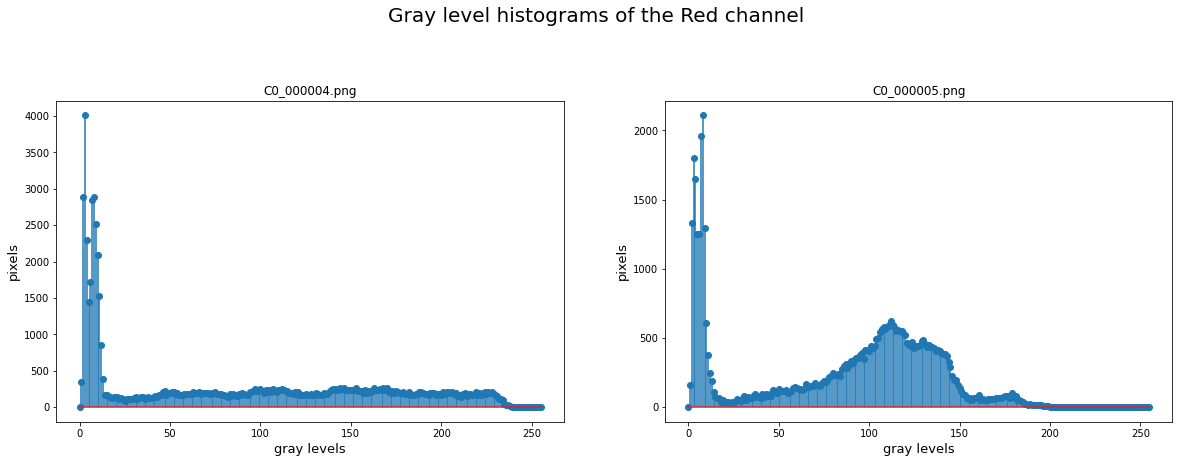

In [6]:
plot_histogram_grid(colour_B, 'Gray level histograms of the Blue channel', nir_names)
plot_histogram_grid(colour_G, 'Gray level histograms of the Green channel', nir_names)
plot_histogram_grid(colour_R, 'Gray level histograms of the Red channel', nir_names)

## todo 
- pack function to get mask in a utils package
- improve graphical representation (grid)

0.0


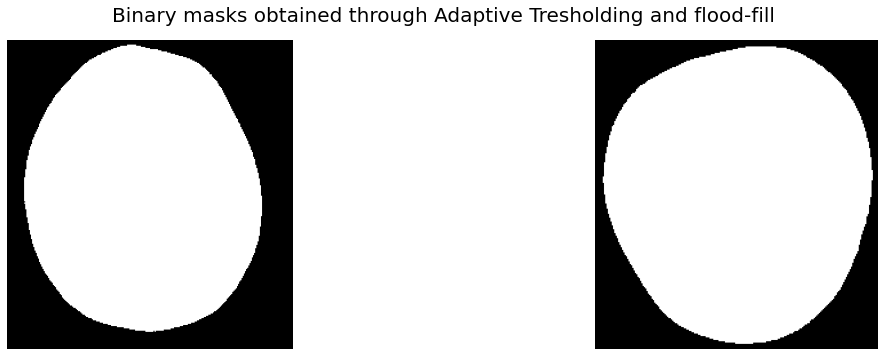

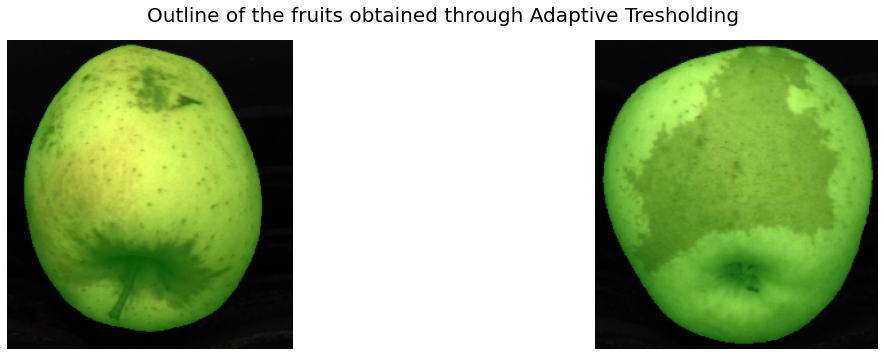

In [7]:
# obtaining the mask and preprocessing imgs

# median blur on images
filtered_colour_images = [cv2.medianBlur(img,5) for img in colour_imgs]

# greyscale image masking 

masks = []

s = process_time()
for img in filtered_colour_images:
    mask = cv2.adaptiveThreshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 5)
    masks.append(mask)

# plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding')
    
# Pad masks and flood-fill the background
masks = [np.pad(m, 1, mode='constant', constant_values=255) for m in masks]
for m in masks:
    cv2.floodFill(m, None, (0,0), 0)
# Downsample the masks to their original size
masks = [m[1:-1,1:-1] for m in masks]
print(process_time() - s)

# plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding and flood-fill')

bounded_images = []

for idx, img in enumerate(colour_imgs):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 'Outline of the fruits obtained through Adaptive Tresholding')

In [8]:
# mask is applied to images
masked_filtered_imgs = [filtered_colour_images[i] & cv2.cvtColor(masks[i], cv2.COLOR_GRAY2BGR) for i in range(len(masks))]

In [9]:
def get_masked_color_space(img, mask, color_space):
    return cv2.cvtColor(img, color_space) #& cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)

In [10]:
"""# Create HSV, HLS, LUV images
colour_space_dict = {
    'BGR': masked_filtered_imgs,
    'HSV': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2HSV_FULL) for i, img in enumerate(filtered_colour_images)],
    'HLS': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2HLS_FULL) for i, img in enumerate(filtered_colour_images)],
    'LUV': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2Luv) for i, img in enumerate(filtered_colour_images)],
    'LAB': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2LAB) for i, img in enumerate(filtered_colour_images)],
    'YCrCb': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2YCrCb) for i, img in enumerate(filtered_colour_images)],
    'YUV': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2YUV) for i, img in enumerate(filtered_colour_images)]
}"""

"# Create HSV, HLS, LUV images\ncolour_space_dict = {\n    'BGR': masked_filtered_imgs,\n    'HSV': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2HSV_FULL) for i, img in enumerate(filtered_colour_images)],\n    'HLS': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2HLS_FULL) for i, img in enumerate(filtered_colour_images)],\n    'LUV': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2Luv) for i, img in enumerate(filtered_colour_images)],\n    'LAB': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2LAB) for i, img in enumerate(filtered_colour_images)],\n    'YCrCb': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2YCrCb) for i, img in enumerate(filtered_colour_images)],\n    'YUV': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2YUV) for i, img in enumerate(filtered_colour_images)]\n}"

In [11]:
# Create HSV, HLS, LUV images
colour_space_dict = {
    'BGR': masked_filtered_imgs,
    'HSV': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2HSV_FULL) for i, img in enumerate(masked_filtered_imgs)],
    'HLS': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2HLS_FULL) for i, img in enumerate(masked_filtered_imgs)],
    'LUV': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2Luv) for i, img in enumerate(masked_filtered_imgs)],
    'LAB': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2LAB) for i, img in enumerate(masked_filtered_imgs)],
    'YCrCb': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2YCrCb) for i, img in enumerate(masked_filtered_imgs)],
    'YUV': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2YUV) for i, img in enumerate(masked_filtered_imgs)]
}

In [12]:
def show_split_channels(imgs, colour_space_name, imgs_names=None):
    for i, img in enumerate(imgs):
        plot_image_grid(cv2.split(img), f'{colour_space_name} Channel division for image {colour_names[i]}', imgs_names)

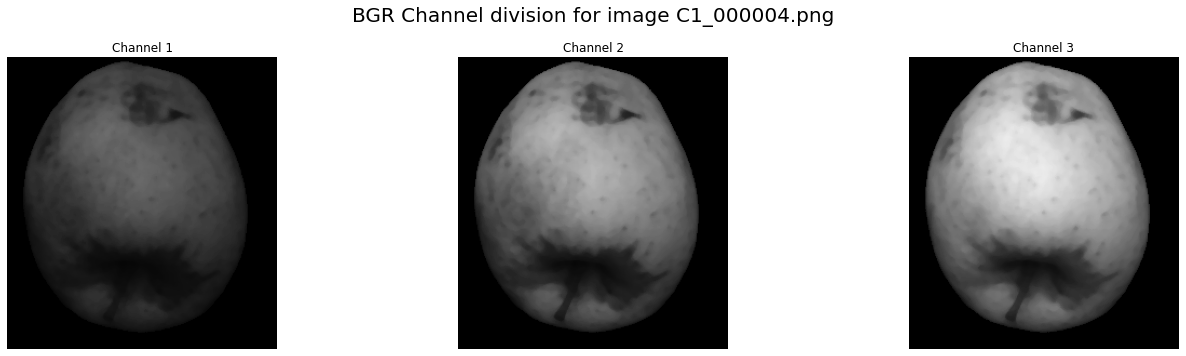

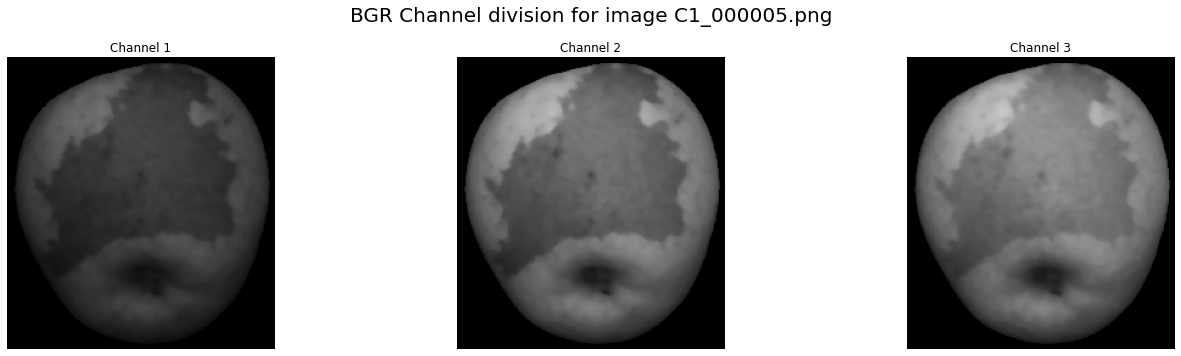

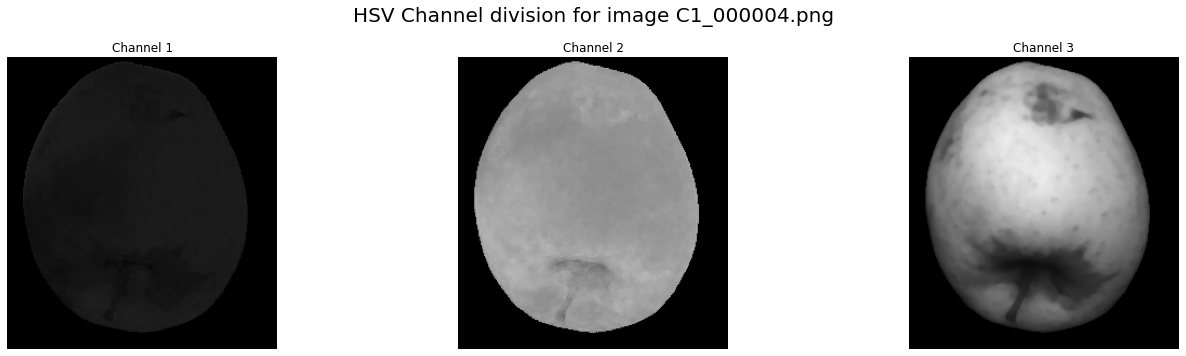

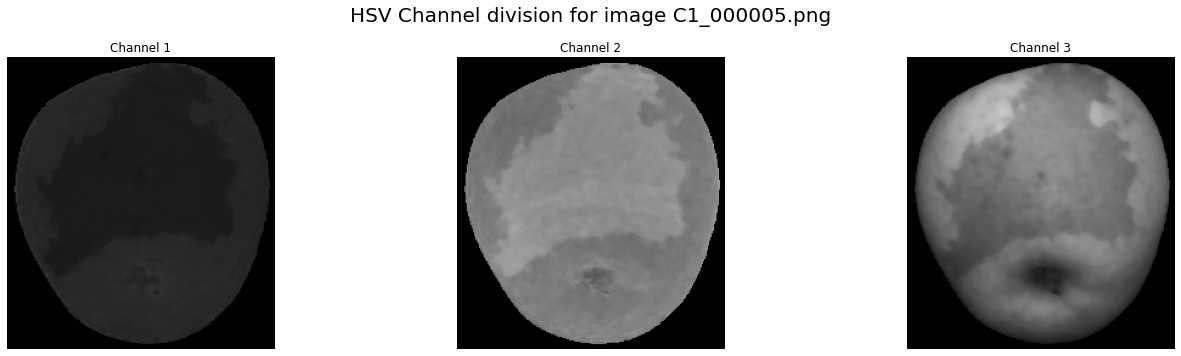

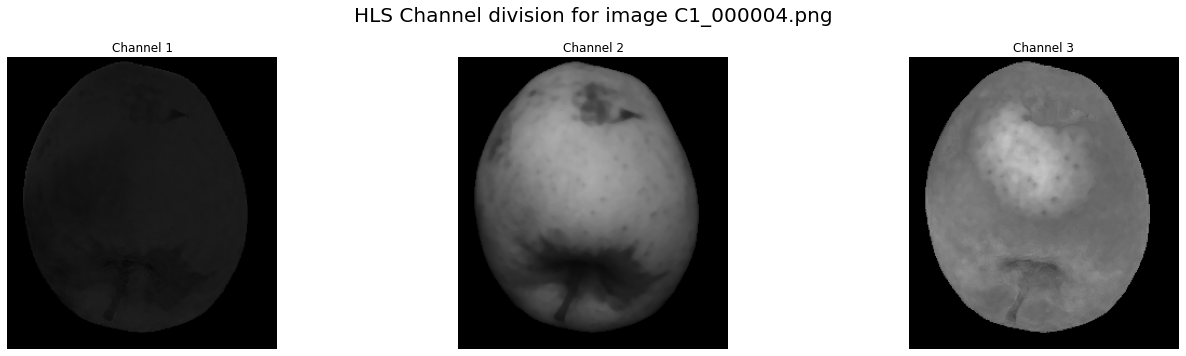

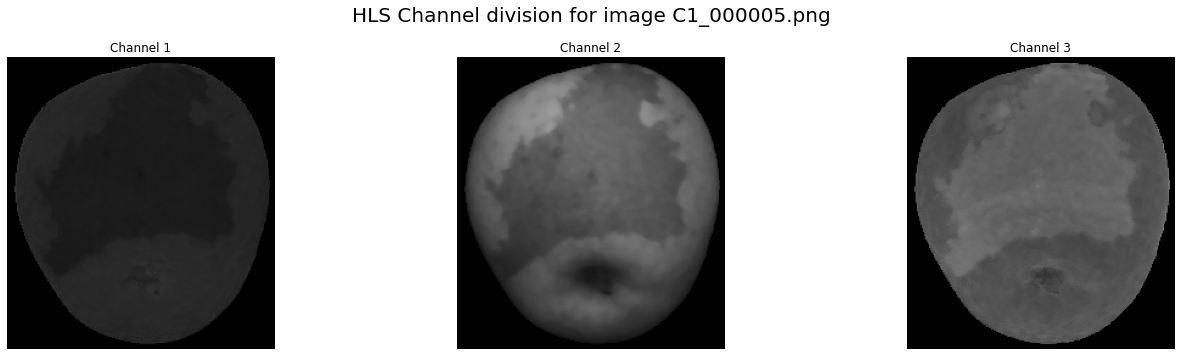

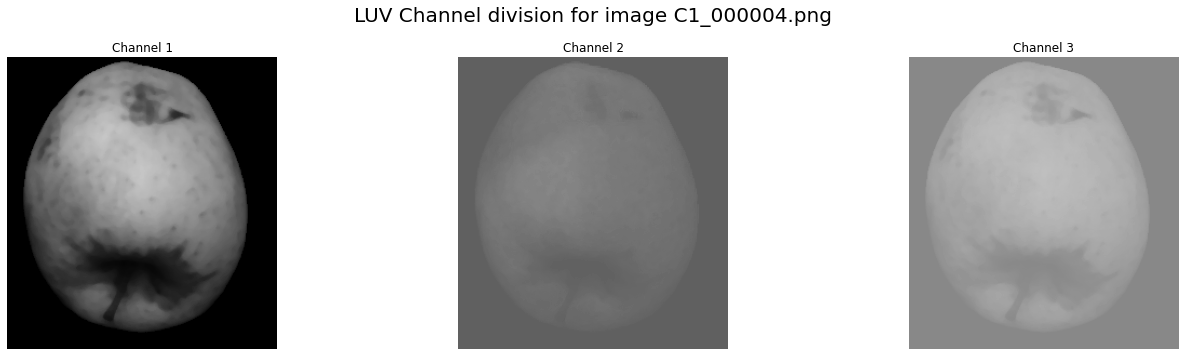

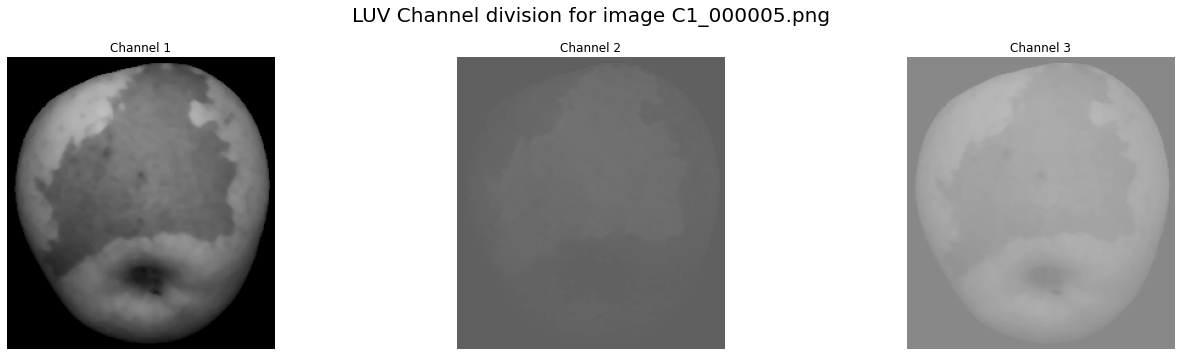

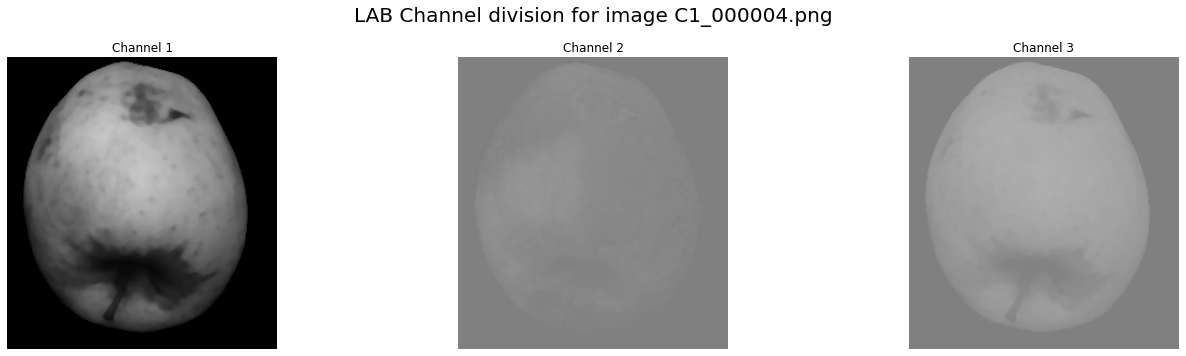

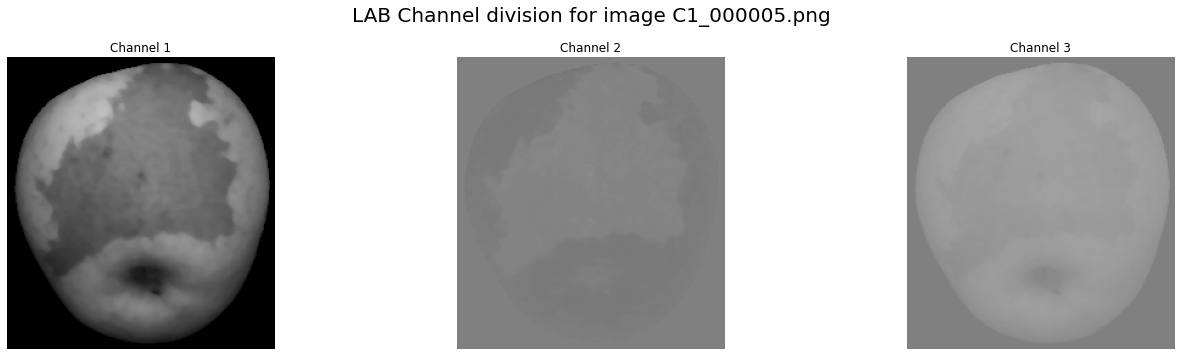

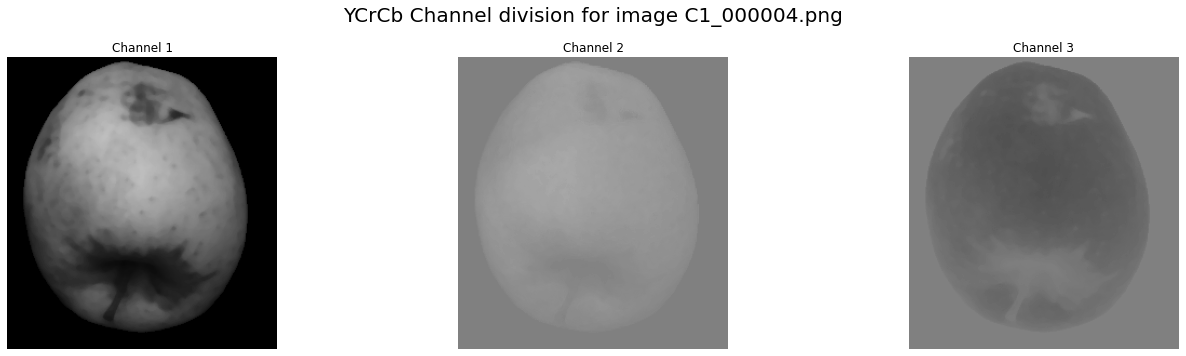

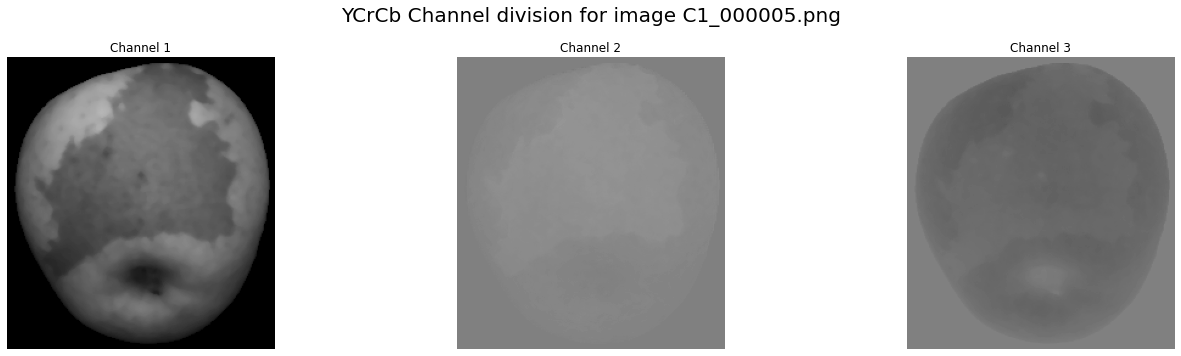

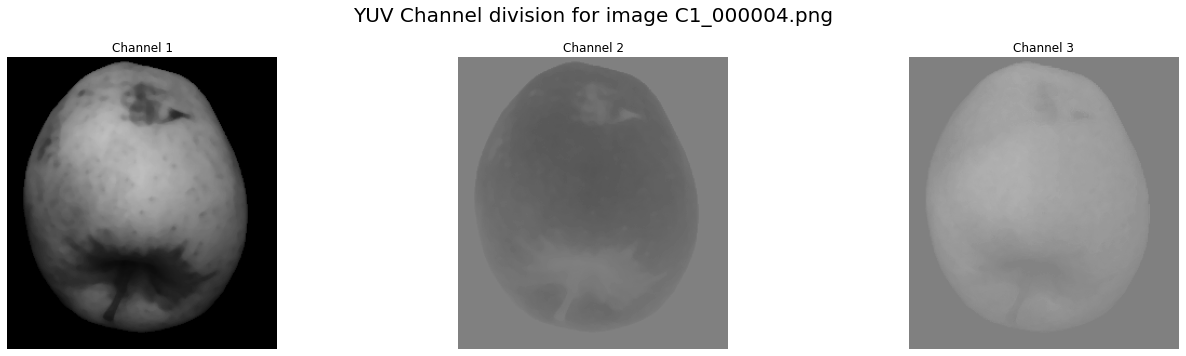

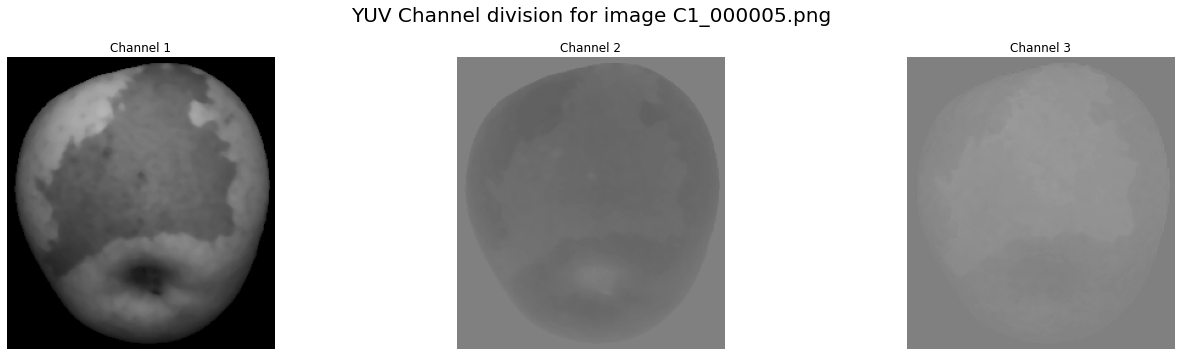

In [13]:
for k in colour_space_dict:
    show_split_channels(colour_space_dict[k], k, imgs_names=[f'Channel {i}' for i in range(1, 4)])

In [14]:
#
colour_space_significant_channels_dict = {
    'BGR': [0, 1, 2],
    'HSV': [0, 1],
    'HLS': [0, 2],
    'LUV': [1, 2],
    'LAB': [1, 2],
    'YCrCb': [1, 2],
    'YUV': [1, 2]
}

In [15]:
def get_k_means_segmentation(img, channels):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.)
    flags = cv2.KMEANS_RANDOM_CENTERS
    Z = np.copy(img)
    Z = Z[:,:,channels]
    Z = Z.reshape(-1,len(channels))
    Z = np.float32(Z)
    centers = 3

    _, labels, _ = cv2.kmeans(Z, centers, None, criteria, 10, flags)

    labels[labels == 1] = 255 // 2
    labels[labels == 2] = 255
    res = labels.reshape(img.shape[0], img.shape[1])

    return res.astype('uint8')

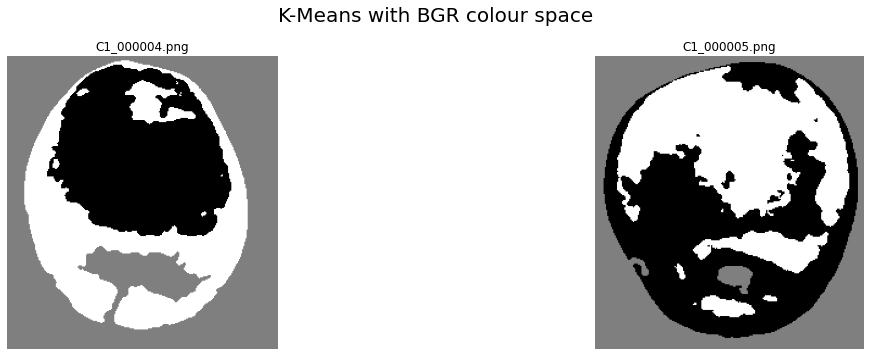

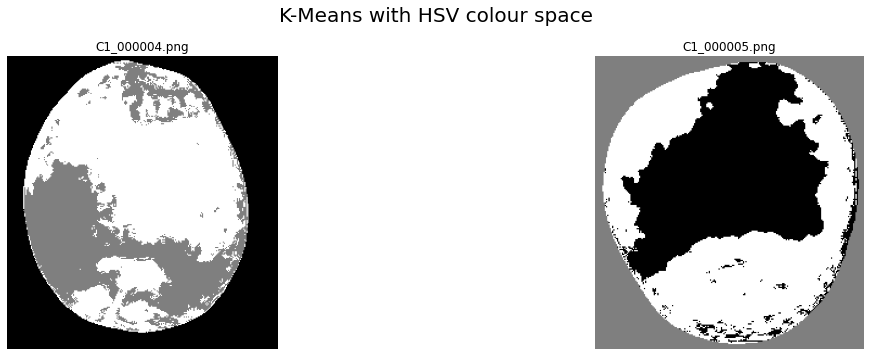

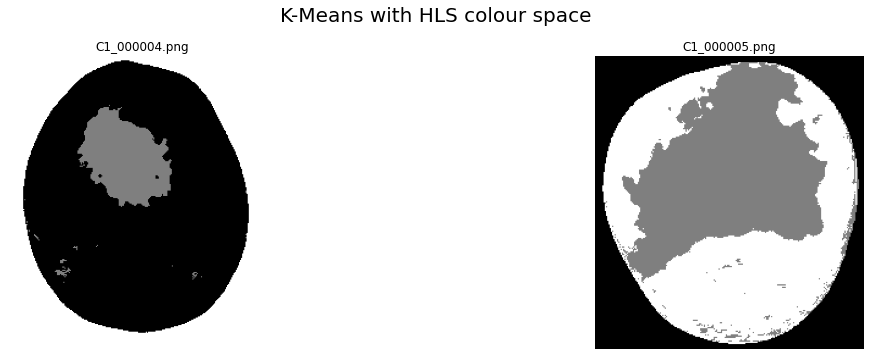

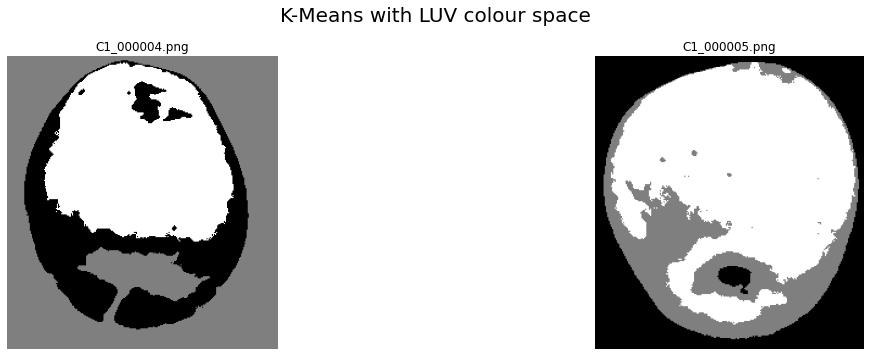

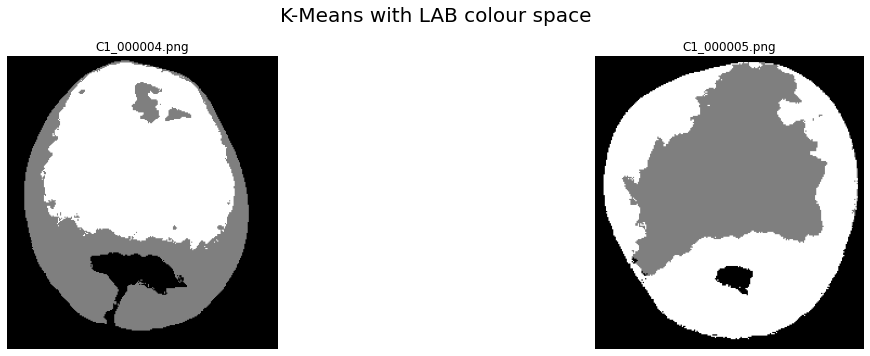

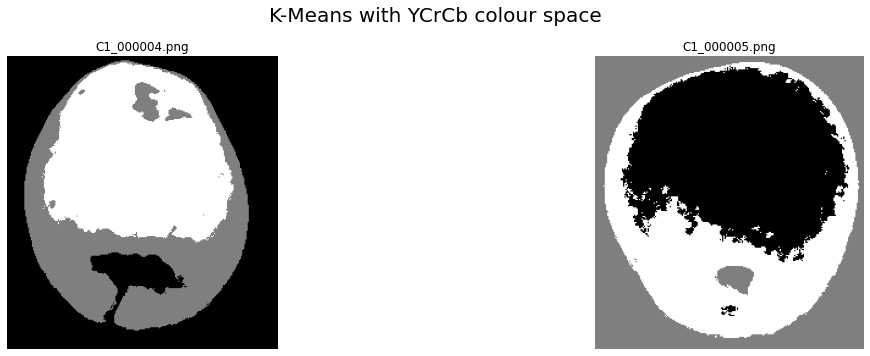

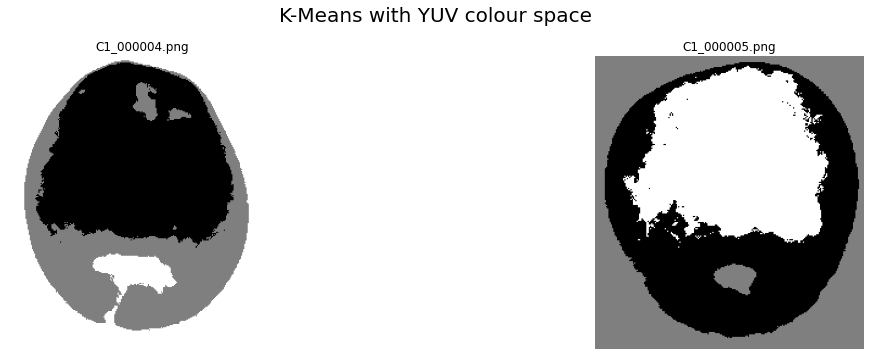

In [16]:

for k in colour_space_dict:
    res = []
    for img in colour_space_dict[k]:
        res.append(get_k_means_segmentation(img, colour_space_significant_channels_dict[k]))
    plot_image_grid(res, f'K-Means with {k} colour space', colour_names)

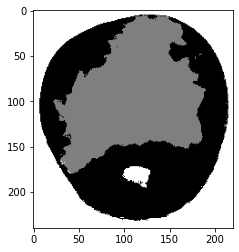

In [17]:
# We take just the LAB color space 
# We take just second kmeans image as a sample
kmeans_lab = get_k_means_segmentation(colour_space_dict['LAB'][1], colour_space_significant_channels_dict['LAB'])
plt.imshow(kmeans_lab, cmap='gray', vmin=0, vmax=255)
plt.show()

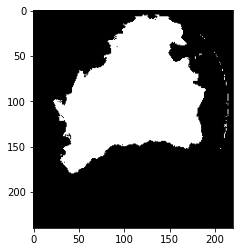

In [18]:
kmeans_lab[kmeans_lab == 255] = 0
kmeans_lab[kmeans_lab == 255 // 2] = 255
roi_mask = kmeans_lab
plt.imshow(roi_mask, cmap='gray', vmin=0, vmax=255)
plt.show()

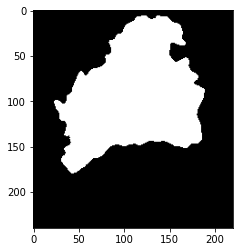

In [19]:
roi_mask = cv2.medianBlur(np.copy(roi_mask),5)
plt.imshow(roi_mask, cmap='gray', vmin=0, vmax=255)
plt.show()

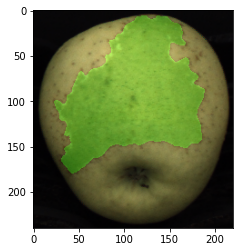

In [24]:
green_mask = cv2.cvtColor(roi_mask, cv2.COLOR_GRAY2BGR)
# Force the bits of every channel except the green at 0
green_mask[:,:,::2] = 0
highlighted_roi = cv2.addWeighted(green_mask, 0.3, colour_imgs[1], 1, 0)
plt.imshow(cv2.cvtColor(highlighted_roi, cv2.COLOR_BGR2RGB))

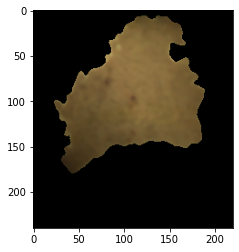

In [30]:
# Get the ROI for each second image in each color space 
colour_space_roi_dict = {k:colour_space_dict[k][1] & cv2.cvtColor(roi_mask, cv2.COLOR_GRAY2BGR) for k in colour_space_dict}
plt.imshow(cv2.cvtColor(colour_space_roi_dict['BGR'], cv2.COLOR_BGR2RGB))

In [290]:
patches = list(extract_patches_2d(colour_space_roi_dict['BGR'], (60, 60)))
roi_patches = [p for p in patches if np.all(p)]
samples_idx = np.random.choice(np.arange(len(roi_patches)), 500, replace=False)

samples = [roi_patches[i] for i in samples_idx]

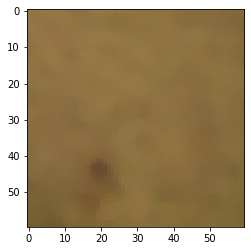

In [291]:
plt.imshow(cv2.cvtColor(samples[0], cv2.COLOR_BGR2RGB))

In [ ]:
num

In [305]:
#channel_num = 2
#channels = [0,1]


def get_mean_and_covariance_matrix(samples, colour_space_fun, channels_num):
    
    covariance_tot = np.zeros((channel_num, channel_num), dtype='float32')
    mean_tot = np.zeros((channel_num,), dtype='float32')

    # CHANGE THE COLOR SPACE OF cvtColor TO THE DEFINED ONE

    for s in samples:
        # s_ab = cv2.cvtColor(s, cv2.COLOR_BGR2LAB)[:, :, channels]
        s_colour_space = colour_space_fun(s)

        s_colour_space = s_colour_space.reshape(-1, channel_num)
        cov, mean = cv2.calcCovarMatrix(s_colour_space, None, cv2.COVAR_NORMAL + cv2.COVAR_ROWS + cv2.COVAR_SCALE)
        covariance_tot = np.add(covariance_tot, cov)
        mean_tot = np.add(mean_tot, mean)

    mean = mean_tot / len(samples)
    print(covariance_tot)
    print(mean)
    # covariance_tot = covariance_tot / len(samples)
    return mean, covariance_tot

In [224]:
# inv_covariance_matrix = np.linalg.inv(covariance_tot)

In [306]:
def get_mahalanobis_distance_img(img, colour_space_fun):
    img = colour_space_fun(img)
    channel_num = img.shape[2]
    # TODO ASSERT
    ##    assert channel_num > 1 , \
    ##    'At least two channels need to be provided.'
    
    mean, covariance = get_mean_and_covariance_matrix(samples, colour_space_fun, channel_num)
    inv_covariance_matrix = np.linalg.inv(covariance)
    
    print(img.shape)

    img_flattened = img.reshape(-1, channel_num)
    img_flattened = img_flattened.astype(np.float64)
    print(img_flattened.shape)
    img_res = [
        cv2.Mahalanobis(i, mean_tot[0], inv_covariance_matrix)  if i[0] != 0 and i[1] != 0 else 200  
        for i in img_flattened
    ]

    img_res = np.array(img_res)
    print(img_res.shape)
    img_res = img_res.reshape((img.shape[0], img.shape[1], 1))
    return img_res

[[ 725.40321211   73.33269815]
 [  73.33269815 2117.26323596]]
[[132.32044389 156.52397444]]
(240, 220, 2)
(52800, 2)
(52800,)


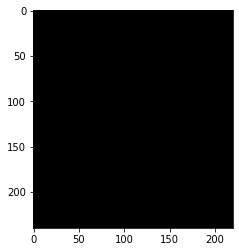

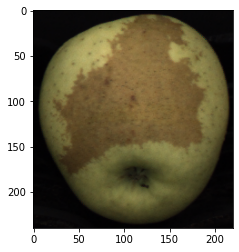

In [310]:
colour_space_fun = lambda img : cv2.cvtColor(img, cv2.COLOR_BGR2LAB)[:,:,1:]
img_res = get_mahalanobis_distance_img(masked_filtered_imgs[1], colour_space_fun) 

img_tresh = np.copy(img_res)

img_tresh[img_tresh >1] = 0

plt.imshow(img_tresh, cmap='gray', vmin=0, vmax=255)
plt.show()

green_mask = cv2.cvtColor(img_tresh.astype(np.uint8), cv2.COLOR_GRAY2BGR)
# Force the bits of every channel except the green at 0
green_mask[:,:,::2] = 0
green_mask[green_mask != 0] = 255
highlighted_roi = cv2.addWeighted(green_mask, 1, colour_imgs[1], 1, 0)
plt.imshow(cv2.cvtColor(highlighted_roi, cv2.COLOR_BGR2RGB))

In [303]:
img_num = 1
yuv_1 = colour_space_dict['YUV'][img_num][:,:,1]
luv_2 = colour_space_dict['LUV'][img_num][:,:,2]

print(yuv_1.shape)
print(luv_2.shape)

yuv_1 = np.expand_dims(yuv_1, axis=2)
luv_2 = np.expand_dims(luv_2, axis=2)

print(yuv_1.shape)
print(luv_2.shape)


img = np.concatenate((yuv_1, luv_2), axis = -1)


print(img.shape)
SIGMA = 3
K = math.ceil(3*SIGMA)
# img = cv2.bilateralFilter(img, 7, 100, 75)

img_flattened = img.reshape(-1, channel_num)
img_flattened = img_flattened.astype(np.float64)
print(img_flattened.shape)
img_res = [
    cv2.Mahalanobis(i, mean_tot[0], inv_covariance_matrix) if i[0] != 0 and i[1] != 0 else 200  
    for i in img_flattened[:,channels]
]

img_res = np.array(img_res)
print(img_res.shape)

(240, 220)
(240, 220)
(240, 220, 1)
(240, 220, 1)
(240, 220, 2)
(52800, 2)
(52800,)


(240, 220, 1)


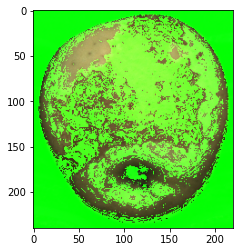

In [232]:
img_res = img_res.reshape((img.shape[0], img.shape[1], 1))
# print(img_res)
print(img_res.shape)
img_tresh = np.copy(img_res)

img_tresh[img_tresh > 2] = 0

green_mask = cv2.cvtColor(img_tresh.astype(np.uint8), cv2.COLOR_GRAY2BGR)
# Force the bits of every channel except the green at 0
green_mask[:,:,::2] = 0
green_mask[green_mask != 0] = 255
highlighted_roi = cv2.addWeighted(green_mask, 1, colour_imgs[img_num], 1, 0)
plt.imshow(cv2.cvtColor(highlighted_roi, cv2.COLOR_BGR2RGB))

In [17]:
for k in colour_space_dict:
    show_split_channels(colour_space_dict[k], k, imgs_names=[f'Channel {i}' for i in range(1, 4)])

In [68]:
masked_lab_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2LAB) for img in filtered_colour_images] 
masked_lab_imgs = [masked_lab_imgs[i] & cv2.cvtColor(masks[i], cv2.COLOR_GRAY2BGR) for i in range(len(masks))]

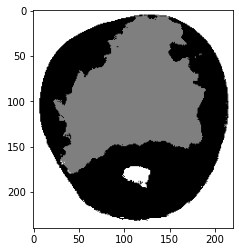

In [67]:
Z = masked_lab_imgs[1] # cv2.cvtColor(masked_filtered_imgs[1], cv2.COLOR_BGR2LAB)
Z = Z[:,:,1:]
Z = Z.reshape(-1,2)
Z = np.float32(Z)
centers = 3

_, labels_1, center_1 = cv2.kmeans(Z, centers, None, criteria, 100, flags)

labels_1[labels_1 == 1] = 255 // 2
labels_1[labels_1 == 2] = 255
res_1 = labels_1.reshape(masked_filtered_imgs[1].shape[0], masked_filtered_imgs[1].shape[1])


'''print(center_1)
print(np.unique(labels_1))

center_1 = np.uint8(center_1)
res_1 = center_1[labels_1]
res_1 = res_1.reshape(masked_filtered_imgs[1].shape[0], masked_filtered_imgs[1].shape[1], 2)[:,:,0]'''

plt.imshow(res_1, cmap='gray', vmin=0, vmax=255)

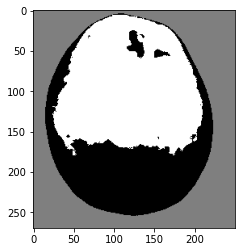

In [66]:
Z = masked_lab_imgs[0]# cv2.cvtColor(masked_filtered_imgs[0], cv2.COLOR_BGR2LAB)
Z = Z[:,:,1:]
Z = Z.reshape(-1,2)
Z = np.float32(Z)

compactness_1, labels_1, center_1 = cv2.kmeans(Z, 3, None, criteria, 100, flags)

labels_1[labels_1 == 1] = 255 // 2
labels_1[labels_1 == 2] = 255
res_1 = labels_1.reshape(masked_filtered_imgs[0].shape[0], masked_filtered_imgs[0].shape[1])

plt.imshow(res_1, cmap='gray', vmin=0, vmax=255)

In [20]:
'''Z = cv2.cvtColor(masked_filtered_imgs[0], cv2.COLOR_BGR2LAB)
Z = Z[:,:,1:]
Z = Z.reshape(-1,2)
Z = np.float32(Z)

compactness, label, center = cv2.kmeans(Z, 3, None, criteria, 100, flags)

center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape(masked_filtered_imgs[0].shape[0], masked_filtered_imgs[0].shape[1], 2)

plt.imshow(cv2.cvtColor(res2[:,:,0], cv2.COLOR_GRAY2RGB))''';

In [21]:
'''reshaped_imgs = [np.copy(img) for img in filtered_colour_images]
reshaped_imgs[0] = reshaped_imgs[0][:reshaped_imgs[1].shape[0], :reshaped_imgs[1].shape[1], :]

reshaped_imgs = [img.reshape((-1, 3)) for img in reshaped_imgs]
for i in reshaped_imgs:
    print(i.shape)
kmeans = KMeans(n_clusters=3, random_state=0).fit(reshaped_imgs[1])

labels = kmeans.predict(reshaped_imgs[1])'''

'reshaped_imgs = [np.copy(img) for img in filtered_colour_images]\nreshaped_imgs[0] = reshaped_imgs[0][:reshaped_imgs[1].shape[0], :reshaped_imgs[1].shape[1], :]\n\nreshaped_imgs = [img.reshape((-1, 3)) for img in reshaped_imgs]\nfor i in reshaped_imgs:\n    print(i.shape)\nkmeans = KMeans(n_clusters=3, random_state=0).fit(reshaped_imgs[1])\n\nlabels = kmeans.predict(reshaped_imgs[1])'

In [22]:
'''labels = [0 if i == 1 else 100 if i == 2 else 255 for i in labels]'''

'labels = [0 if i == 1 else 100 if i == 2 else 255 for i in labels]'

In [23]:
'''plt.imshow(np.array(labels).reshape(filtered_colour_images[1].shape[0], filtered_colour_images[1].shape[1]), cmap='gray', vmin=0, vmax=255)'''

"plt.imshow(np.array(labels).reshape(filtered_colour_images[1].shape[0], filtered_colour_images[1].shape[1]), cmap='gray', vmin=0, vmax=255)"

In [24]:
# Create HSV, HLS, LUV images
colour_space_dict = {
    'BGR': colour_imgs,
    'HSV': [cv2.cvtColor(img, cv2.COLOR_BGR2HSV_FULL) for img in filtered_colour_images],
    'HLS': [cv2.cvtColor(img, cv2.COLOR_BGR2HLS_FULL) for img in filtered_colour_images],
    'LUV': [cv2.cvtColor(img, cv2.COLOR_BGR2Luv) for img in filtered_colour_images],
    'LAB': [cv2.cvtColor(img, cv2.COLOR_BGR2LAB) for img in filtered_colour_images],
    'YCrCb': [cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb) for img in filtered_colour_images],
    'YUV': [cv2.cvtColor(img, cv2.COLOR_BGR2YUV) for img in filtered_colour_images]
}
'''
print(hsv_imgs[0].shape)
print(hls_imgs[0].shape)
print(luv_imgs[0].shape)
print(lab_imgs[0].shape)
print(ycrcb_imgs[0].shape)
print(yuv_imgs[0].shape)''';

In [25]:
def show_split_channels(imgs, colour_space_name, imgs_names=None):
    assert imgs_names is None or len(imgs_names) == len(imgs), \
        '`images_names` must not be provided or it must have the same size as `images`.'
    
    channel_1 = []; channel_2 = []; channel_3 = []

    for img in imgs:
        ch1, ch2, ch3 = cv2.split(img)
        channel_1.append(ch1)
        channel_2.append(ch2)
        channel_3.append(ch3)

    colour_space_name = f'({colour_space_name})'
    # Plot the Channels of the images
    plot_image_grid(channel_1, f'First channel {colour_space_name}', imgs_names)
    plot_image_grid(channel_2, f'Second channel {colour_space_name}', imgs_names)
    plot_image_grid(channel_3, f'Third channel {colour_space_name}', imgs_names)

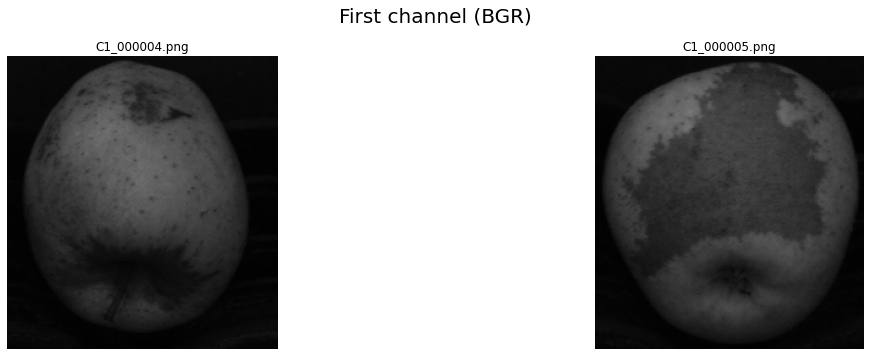

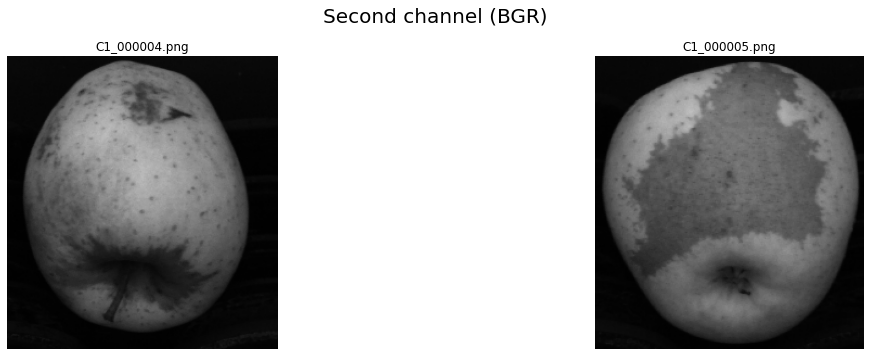

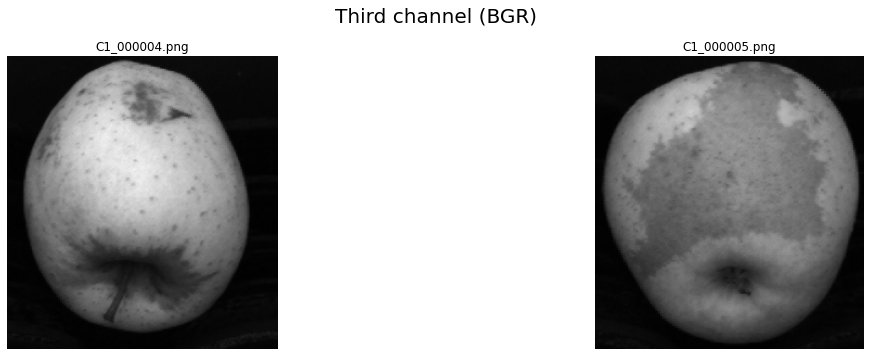

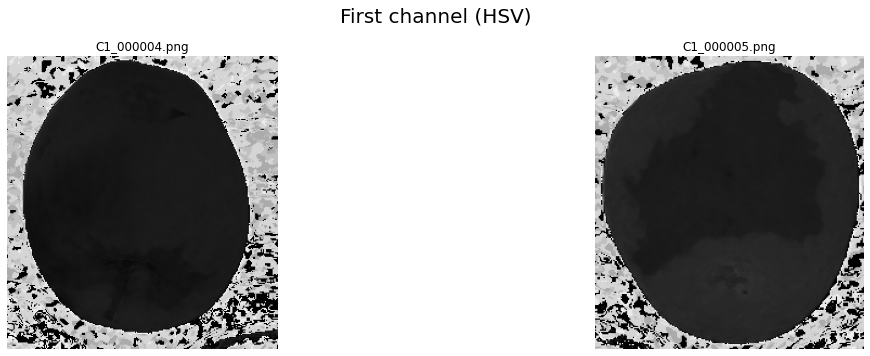

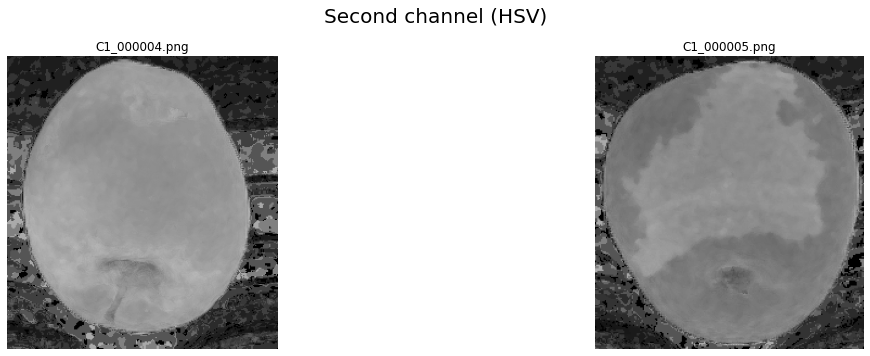

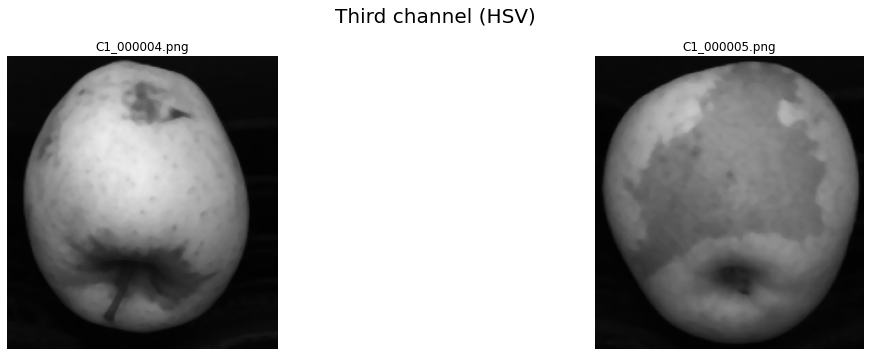

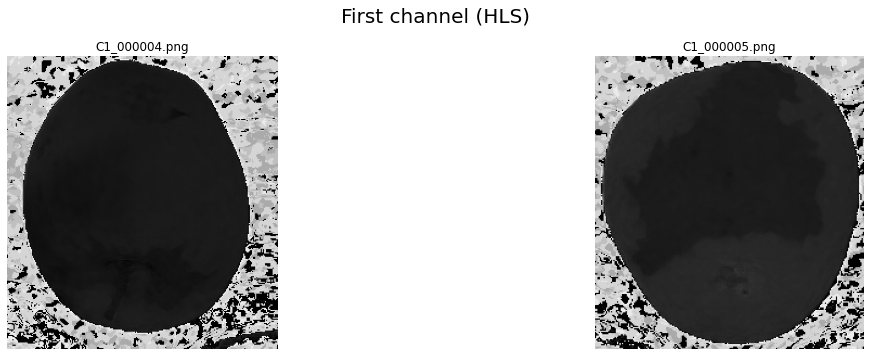

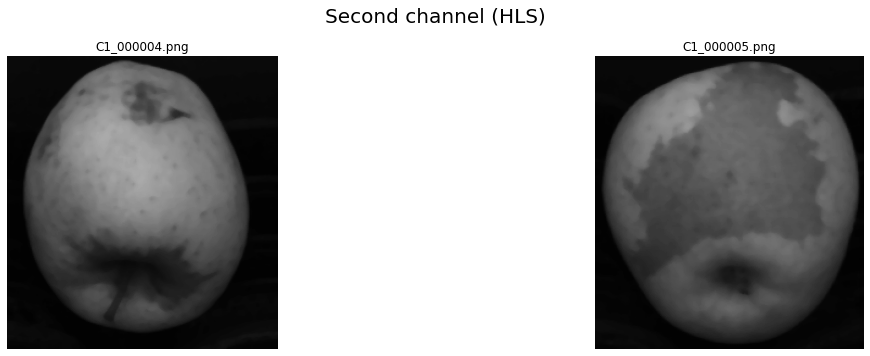

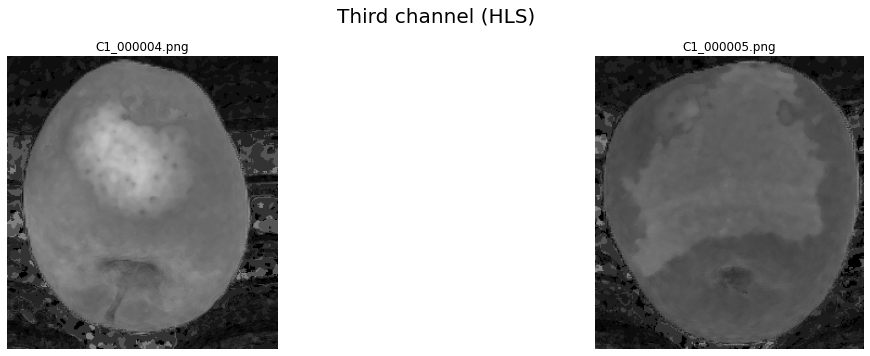

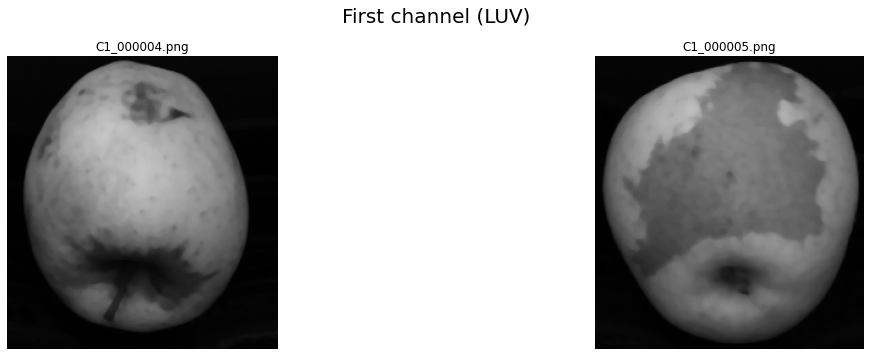

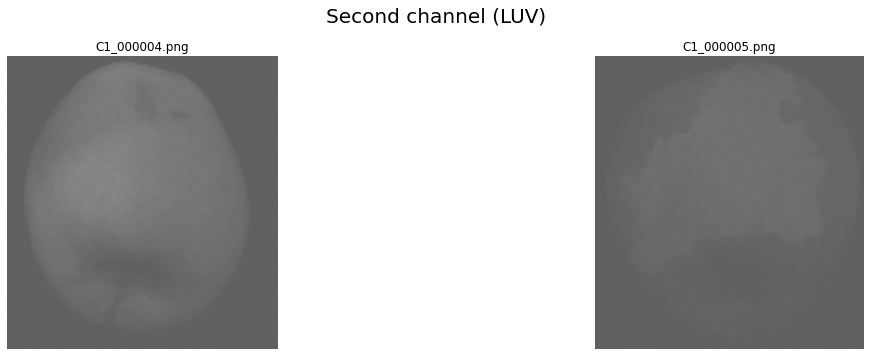

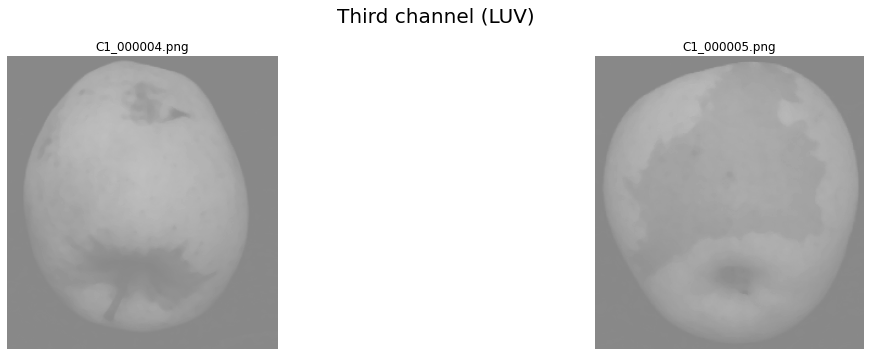

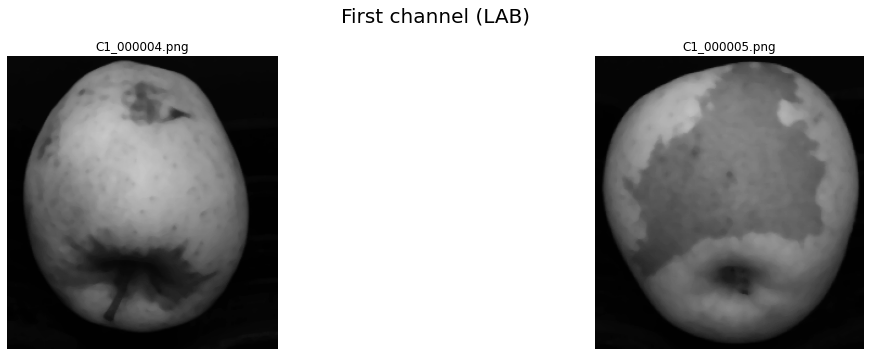

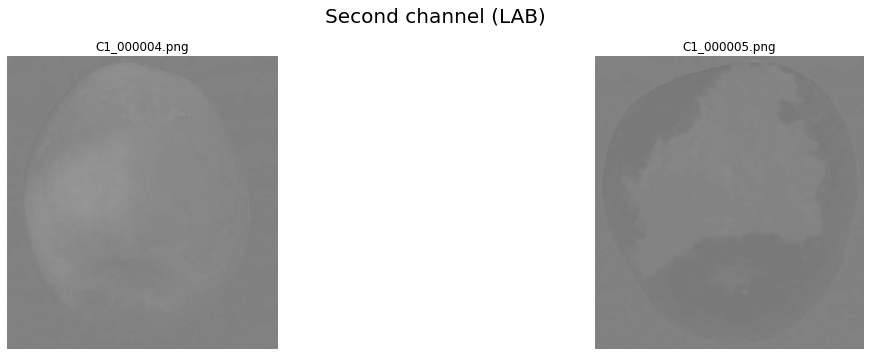

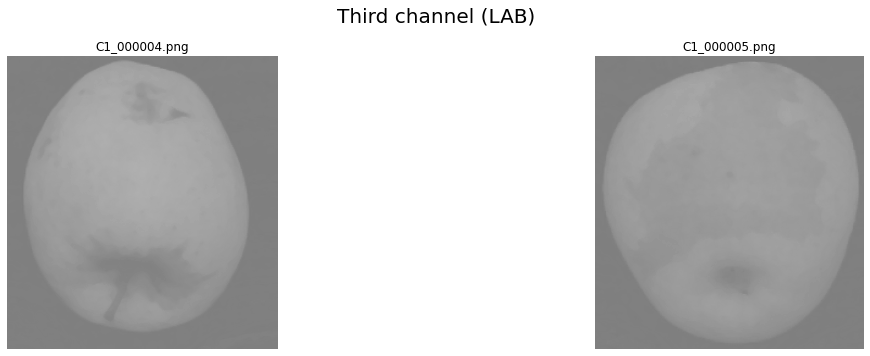

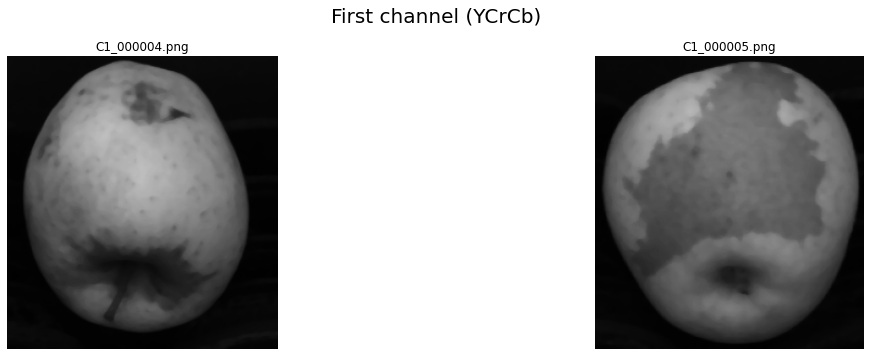

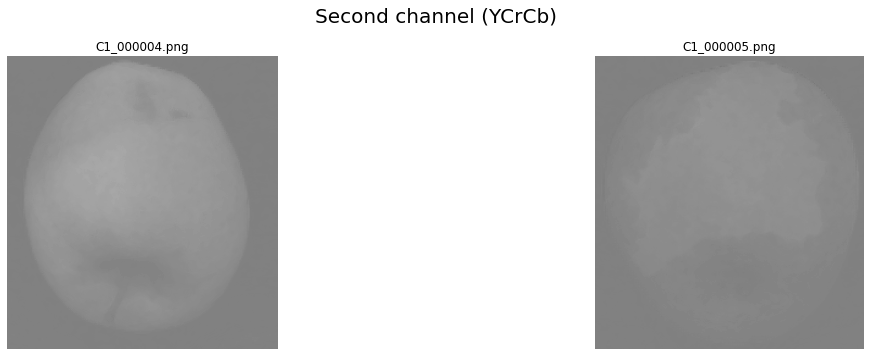

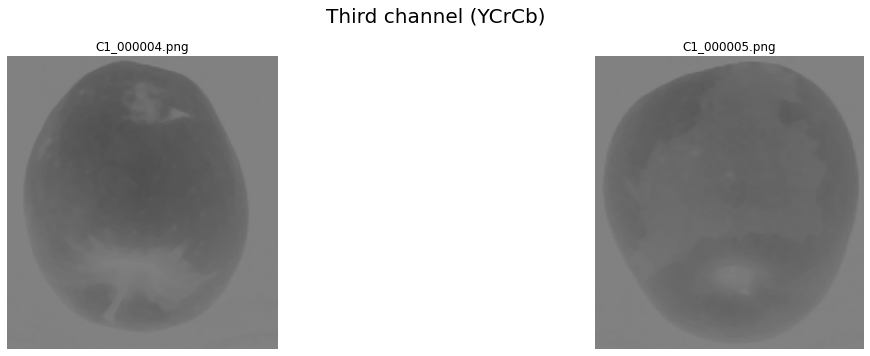

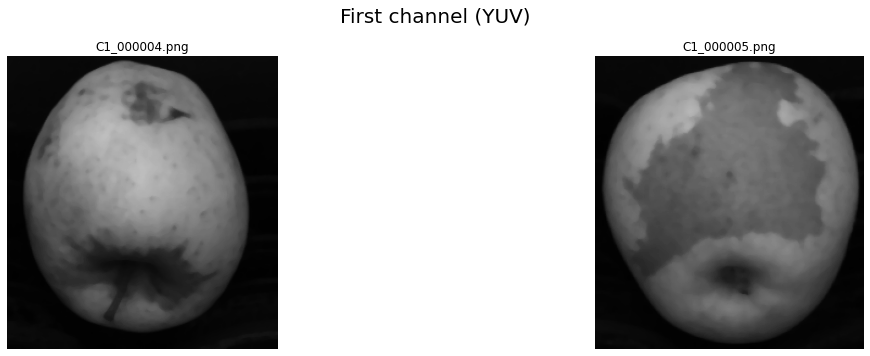

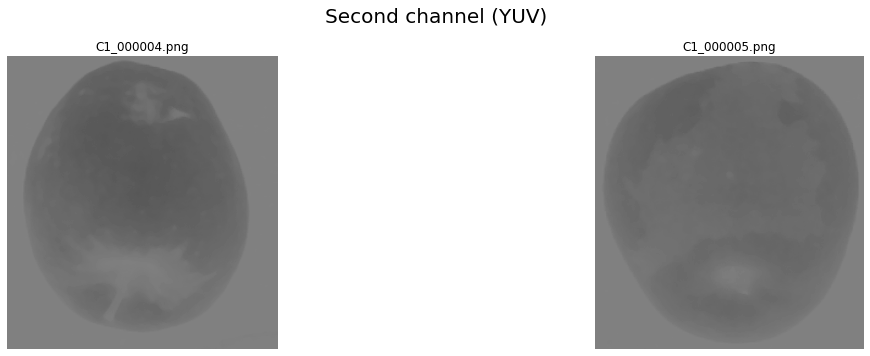

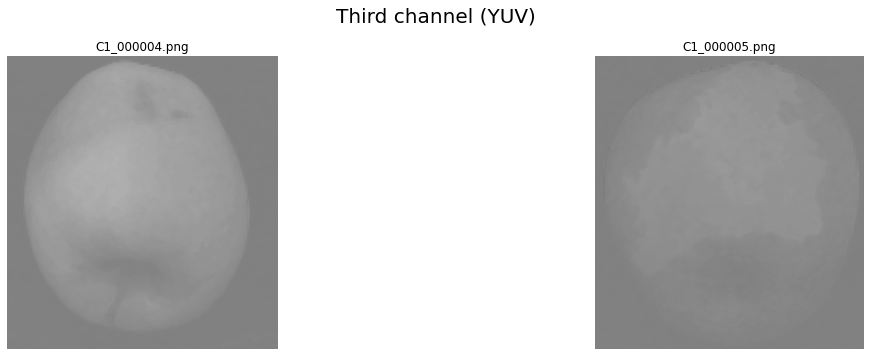

In [26]:
for k in colour_space_dict:
    show_split_channels(colour_space_dict[k], k, imgs_names=colour_names)

In [27]:
# plot_histogram_grid(colour_B, 'Gray level histograms of the Blue channel', nir_names)
# plot_histogram_grid(colour_G, 'Gray level histograms of the Green channel', nir_names)
# plot_histogram_grid(colour_R, 'Gray level histograms of the Red channel', nir_names)

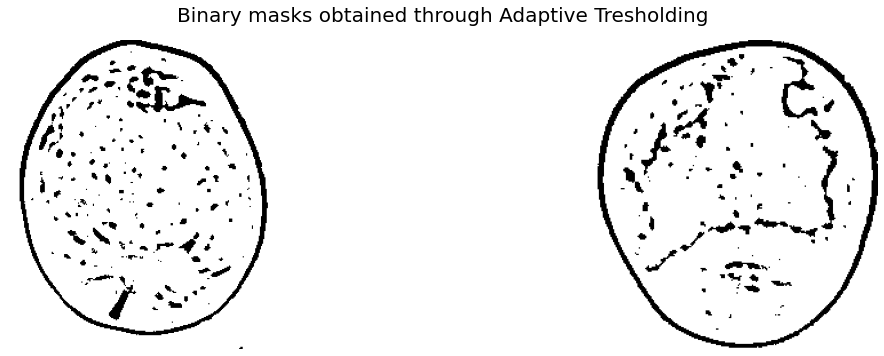

0.15625


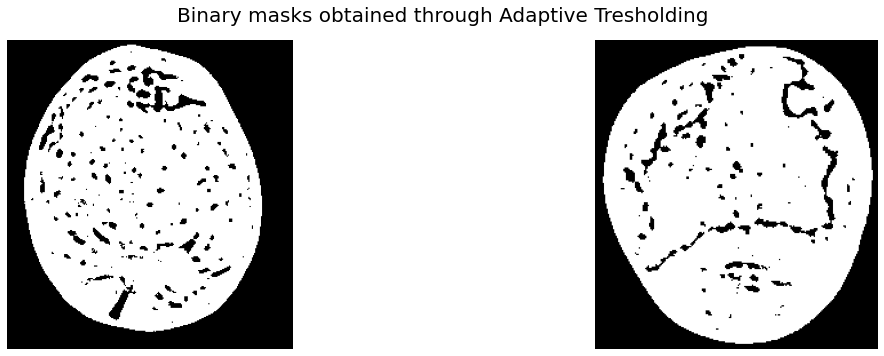

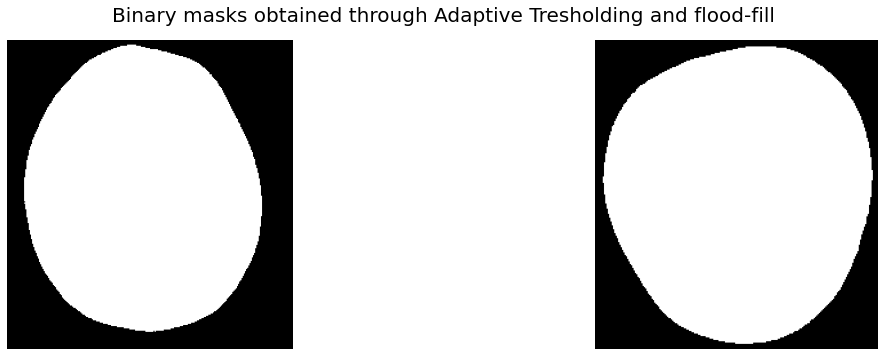

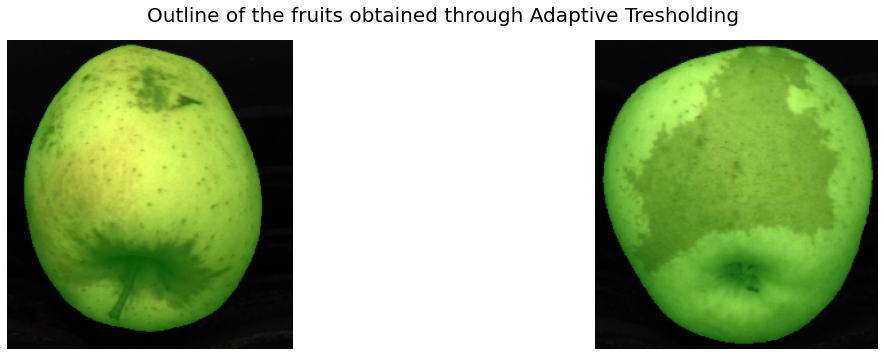

In [28]:
masks = []

s = process_time()
for img in filtered_colour_images:
    mask = cv2.adaptiveThreshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 5)
    masks.append(mask)

plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding')
    

# Pad masks and flood-fill the background
masks = [np.pad(m, 1, mode='constant', constant_values=255) for m in masks]
for m in masks:
    cv2.floodFill(m, None, (0,0), 0)
# Downsample the masks to their original size
masks = [m[1:-1,1:-1] for m in masks]
print(process_time() - s)

plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding and flood-fill')

bounded_images = []

for idx, img in enumerate(colour_imgs):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 'Outline of the fruits obtained through Adaptive Tresholding')

In [29]:
masked_nir_imgs = [nir_imgs[i] & masks[i] for i in range(len(masks))]


masked_filtered_imgs = [filtered_colour_images[i] & cv2.cvtColor(masks[i], cv2.COLOR_GRAY2BGR) for i in range(len(masks))]


masked_colour_imgs = [colour_imgs[i] &  cv2.cvtColor(masks[i], cv2.COLOR_GRAY2BGR) for i in range(len(masks))]

In [30]:
covariance_tot = np.zeros((2, 2), dtype='float32')
mean_tot = np.zeros((2,), dtype='float32')

# Iterate over samples to compute the reference color (i.e. mean of samples) and its total covariance
for s in masked_filtered_imgs:
    s_ab = cv2.cvtColor(s, cv2.COLOR_BGR2LAB)[:, :, 1:3]
    print(s_ab.shape)
    s_ab_r = s_ab.reshape(s_ab.shape[0] * s_ab.shape[1], 2)
    print(s_ab_r.shape)
    cov, mean = cv2.calcCovarMatrix(s_ab_r, None, cv2.COVAR_NORMAL + cv2.COVAR_ROWS + cv2.COVAR_SCALE)
    covariance_tot = np.add(covariance_tot, cov)
    mean_tot = np.add(mean_tot, mean)
    
mean_tot = mean_tot / len(masked_filtered_imgs)

(270, 250, 2)
(67500, 2)
(240, 220, 2)
(52800, 2)


In [31]:
inv_covariance_matrix = np.linalg.inv(covariance_tot)

In [32]:
img = masked_filtered_imgs[0]
img_flattened = img.reshape(img.shape[0] * img.shape[1], 3)
img_flattened = img_flattened.astype(np.float64)

print(mean_tot.shape)

img_res = [
    cv2.Mahalanobis(i, mean_tot[-1], inv_covariance_matrix) if i[0] != 0 and i[1] != 0 else 200  
    for i in img_flattened[:,1:]
]
img_res = np.array(img_res)
#print(img_flattened[0].shape) 
#print(mean_tot.shape)

#cv2.Mahalanobis(img_flattened[0], mean_tot[-1], inv_covariance_matrix)



'''f = lambda v1: cv2.Mahalanobis(v1, mean_tot, inv_covariance_matrix)
f_arr = np.frompyfunc(f, 1, 1)

res_img = f_arr(img_flattened)''';

#cv2.Mahalanobis(v1, v2, inv_covariance_matrix)

(1, 2)


In [33]:
print(img_res.shape)

(67500,)


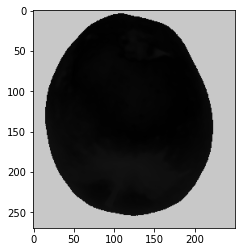

In [34]:
img_res = img_res.reshape((img.shape[0], img.shape[1]))
# print(img_res)
img_tresh = np.copy(img_res)

# img_tresh[img_tresh > 23] = 0

plt.imshow(img_tresh, cmap='gray', vmin=0, vmax=255)

In [ ]:
img = masked_filtered_imgs[1]

In [ ]:
s = img
s_ab = cv2.cvtColor(s, cv2.COLOR_BGR2LAB)[:, :, 1:3]
s_ab_r = s_ab.reshape(s_ab.shape[0] * s_ab.shape[1], 2)
cov, mean = cv2.calcCovarMatrix(s_ab_r, None, cv2.COVAR_NORMAL + cv2.COVAR_ROWS + cv2.COVAR_SCALE)
covariance_tot = cov
mean_tot = mean

print(covariance_tot)
print(mean_tot)

In [ ]:
img_flattened = img.reshape(img.shape[0] * img.shape[1], 3)
img_flattened = img_flattened.astype(np.float64)

print(mean_tot.shape)

img_res = [cv2.Mahalanobis(i, mean_tot[-1], inv_covariance_matrix) for i in img_flattened[:,1:3]]
img_res = np.array(img_res)

In [ ]:
img_res = img_res.reshape((img.shape[0], img.shape[1]))
# print(img_res)
img_tresh = np.copy(img_res)

# img_tresh[img_tresh > 23] = 0

plt.imshow(img_tresh, cmap='gray', vmin=0, vmax=255)

In [35]:
img = masked_filtered_imgs[1]